## Building a QSAR Model to predict molecule's ability to inhibit the target protein linked to Alzheimer's, Beta-secretase 1

Drug discovery is a long process with high costs, on average taking 12 years and $10 billion dollars. The old process relied on a scientist or pharmaceutical companies expertise or past knowledge of experiments to design chemical compounds that may or may not exhibit the desired characteristics on thier target gene or protein. Now with decades of past expermimental data, we can apply machine learning to build predictive models that can predict a compound's biological activity to help speed up the selection of the drug targets. These tools can be supremely benefiecial in reducing reserach costs and speeding up clinical reserach to bring more helpful drugs to those afflicted. Pharmacuitical companies are realising the power of using past experiment data to to better predict the compund's chemical characteristics. As powerful machine learning tools are applied to chemical data, we can use these models for onitoring important chemical- protein activities, especially as advances are made to manufacturing novel compounds.

A QSAR (quantitaive-structured activity relationship) model helps researchers predict a given chemical compound's potential activity on a target protein. If a researcher is studying the effects of inhibition of a disease-causing target protein, they can use past experimental compunds to train a model to predict the biological activity of an unseen compund. This model will use the derived features of over 9000 compunds previously tested for thier ability to inhibit the target protein, Beta-secretase 1, which is measured by pIC50. The descriptors, 1-D and 2-D descriptors that desribe the molecules' physical composition, will be drived using 3rd party software, PaDEL and will be modeled in 2 seperate ways: a model to predict whether a compound will be active (inhibits protein) or inactive (displays no significant effect on a protein), as well as a regression model that would predict the actual pIC50 value of the supplied compound.

Credit: https://github.com/ashiwoku/QSAR-model

In [ ]:
# Install dependencies / requirements 
!pip install chembl-webresource-client rdkit-pypi==2021.3.1.5

     |████████████████████████████████| 18.0MB 264kB/s 


### QSAR Model Beta-secretase 1: Data Wrangling

In [ ]:
import pandas as pd
from chembl_webresource_client.new_client import new_client

In [ ]:
## Protein of interest is Beta-Secretase, a protein associated with ALzeihemers's Disease
target_protein = new_client.target
target_query = target_protein.search('Beta-secretase').filter(target_type='SINGLE PROTEIN').filter(organism='Homo sapiens')

data = pd.DataFrame.from_dict(target_query)
data

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'Q9Y5Z0', 'xref_name': None, 'xre...",Homo sapiens,Beta secretase 2,18.0,False,CHEMBL2525,"[{'accession': 'Q9Y5Z0', 'component_descriptio...",SINGLE PROTEIN,9606
1,"[{'xref_id': 'Beta-secretase_1', 'xref_name': ...",Homo sapiens,Beta-secretase 1,18.0,False,CHEMBL4822,"[{'accession': 'P56817', 'component_descriptio...",SINGLE PROTEIN,9606
2,"[{'xref_id': 'P05067', 'xref_name': None, 'xre...",Homo sapiens,Beta amyloid A4 protein,16.0,False,CHEMBL2487,"[{'accession': 'P05067', 'component_descriptio...",SINGLE PROTEIN,9606
3,[],Homo sapiens,Gamma-secretase-activating protein,14.0,False,CHEMBL3638343,"[{'accession': 'A4D1B5', 'component_descriptio...",SINGLE PROTEIN,9606
4,"[{'xref_id': 'Q9NZ42', 'xref_name': None, 'xre...",Homo sapiens,Gamma-secretase subunit PEN-2,13.0,False,CHEMBL2374,"[{'accession': 'Q9NZ42', 'component_descriptio...",SINGLE PROTEIN,9606
...,...,...,...,...,...,...,...,...,...
282,[],Homo sapiens,Growth/differentiation factor 15,2.0,False,CHEMBL3120039,"[{'accession': 'Q99988', 'component_descriptio...",SINGLE PROTEIN,9606
283,[],Homo sapiens,Stromal cell-derived factor 1,2.0,False,CHEMBL3286074,"[{'accession': 'P48061', 'component_descriptio...",SINGLE PROTEIN,9606
284,[],Homo sapiens,Prosaposin,2.0,False,CHEMBL3580523,"[{'accession': 'P07602', 'component_descriptio...",SINGLE PROTEIN,9606
285,[],Homo sapiens,Melanocyte protein PMEL,2.0,False,CHEMBL3712988,"[{'accession': 'P40967', 'component_descriptio...",SINGLE PROTEIN,9606


In [ ]:
## we want only the first protein: Beta secratese 1 
chosen_one = data.iloc[1]['target_chembl_id']
chosen_one

'CHEMBL4822'

In [ ]:
target_activity = new_client.activity
target_query = target_activity.filter(target_chembl_id=chosen_one).filter(standard_type='IC50')

In [ ]:
df = pd.DataFrame.from_dict(target_query)

In [ ]:
df ## constains all of the compunds that have been tested in this protein.

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,78857,[],CHEMBL653511,Inhibitory activity against Beta-secretase 1 w...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,None,None,CHEMBL1136466,Bioorg. Med. Chem. Lett.,2003,"{'bei': '6.39', 'le': '0.12', 'lle': '7.82', '...",CHEMBL406146,HGLUVALLEUPNSASPALAGLUPHEOH,CHEMBL406146,6.38,False,http://www.openphacts.org/units/Nanomolar,260010,=,1,True,=,None,IC50,nM,None,413.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,None,None,IC50,nM,UO_0000065,None,413.0
1,None,391560,[],CHEMBL653332,Compound was tested for its inhibitory activit...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,None,None,CHEMBL1144938,J. Med. Chem.,2003,"{'bei': '9.74', 'le': '0.19', 'lle': '10.44', ...",CHEMBL78946,None,CHEMBL78946,8.70,True,http://www.openphacts.org/units/Nanomolar,274693,=,1,True,=,None,IC50,nM,None,2.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,None,None,IC50,uM,UO_0000065,None,0.002
2,None,391983,[],CHEMBL653512,Inhibition of human Beta-secretase 1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,None,None,CHEMBL1147464,Bioorg. Med. Chem. Lett.,2004,"{'bei': '8.43', 'le': '0.17', 'lle': '3.99', '...",CHEMBL324109,None,CHEMBL324109,6.34,False,http://www.openphacts.org/units/Nanomolar,219979,=,1,True,=,None,IC50,nM,None,460.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,None,None,IC50,uM,UO_0000065,None,0.46
3,None,395858,[],CHEMBL653512,Inhibition of human Beta-secretase 1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,None,None,CHEMBL1147464,Bioorg. Med. Chem. Lett.,2004,"{'bei': '6.84', 'le': '0.13', 'lle': '3.09', '...",CHEMBL114147,None,CHEMBL114147,5.05,False,http://www.openphacts.org/units/Nanomolar,219988,=,1,True,=,None,IC50,nM,None,9000.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,None,None,IC50,uM,UO_0000065,None,9.0
4,None,395859,[],CHEMBL653512,Inhibition of human Beta-secretase 1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,None,None,CHEMBL1147464,Bioorg. Med. Chem. Lett.,2004,"{'bei': '6.34', 'le': '0.12', 'lle': '1.68', '...",CHEMBL419949,None,CHEMBL419949,5.25,False,http://www.openphacts.org/units/Nanomolar,219982,=,1,True,=,None,IC50,nM,None,5600.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,None,None,IC50,uM,UO_0000065,None,5.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10151,None,19482230,[],CHEMBL4480749,Inhibition of human BACE1 (1 to 460 residues) ...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC(Cc1cc2ccccc2nc1N)C(=O)NC[C@@]12CCCO[C@@H]1C...,None,None,CHEMBL4480382,MedChemComm,2019,"{'bei': '11.65', 'le': '0.22', 'lle': '1.77', ...",CHEMBL4565226,None,CHEMBL4565226,4.47,False,http://www.openphacts.org/units/Nanomolar,3257930,=,1,True,=,None,IC50,nM,None,34000.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,None,None,IC50,uM,UO_0000065,None,34.0
10152,None,19482231,[],CHEMBL4480749,Inhibition of human BACE1 (1 to 460 residues) ...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,Nc

In [ ]:
## Dropping all the null values. (lost 108 observations)
df.dropna(subset=['standard_value'], inplace=True)

In [ ]:
## Saving to csv 
df.to_csv('Beta-secretase-1.csv', index=False)

In [ ]:
data = pd.read_csv('Beta-secretase-1.csv')

In [ ]:
data.shape

(10042, 45)

In [ ]:
## Changing the standard values to class type for classification type model. 
bioactivity_class =[]

for x in data.standard_value:
    if float(x) >= 10000:
        bioactivity_class.append('inactive')
    elif float(x) < 1000:
        bioactivity_class.append('active')
    else:
        bioactivity_class.append('min effect')

In [ ]:
from collections import Counter
Counter(bioactivity_class)

Counter({'active': 6650, 'inactive': 1426, 'min effect': 1966})

In [ ]:
## There is imbalance in the set of active and inactive compunds. 
## Now, we make a dataframe containing only the chembl_id, standard_value, canonical smile, and bioactivity class.
data['bioactivity_class'] = bioactivity_class
data2 = data[['bioactivity_class', 'molecule_chembl_id', 'canonical_smiles', 'standard_value']]
data2.reset_index(inplace=True)

In [ ]:
data2

,index,bioactivity_class,molecule_chembl_id,canonical_smiles,standard_value
0,0,active,CHEMBL406146,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,413.0
1,1,active,CHEMBL78946,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,2.0
2,2,active,CHEMBL324109,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,460.0
3,3,min effect,CHEMBL114147,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,9000.0
4,4,min effect,CHEMBL419949,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,5600.0
...,...,...,...,...,...
10037,10037,inactive,CHEMBL4565226,CC(Cc1cc2ccccc2nc1N)C(=O)NC[C@@]12CCCO[C@@H]1C...,34000.0
10038,10038,inactive,CHEMBL4520156,Nc1nc2ccccc2cc1CCC(=O)N1CC[C@H]2OCCC[C@@]2(Cc2...,84000.0
10039,10039,inactive,CHEMBL4585673,Nc1nc2ccccc2cc1CCC(=O)NC[C@@]12CCCO[C@@H]1CCOC2,29000.0
10040,10040,inactive,CHEMBL4546115,COc1ccc2c(c1)[C@@H](O)[C@@]1(CCN(C(=O)CCc3cc4c...,55000.0


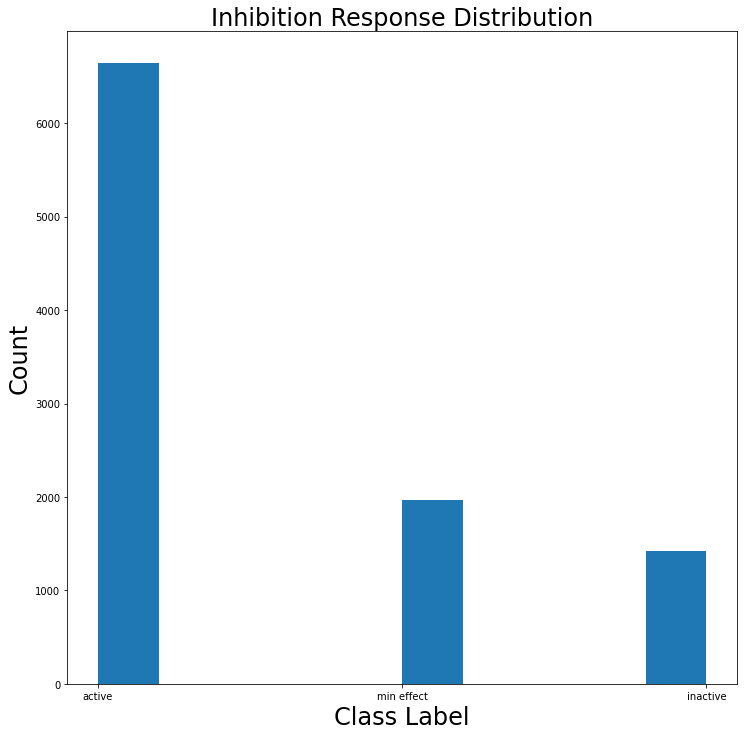

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.hist(data2['bioactivity_class'])

plt.xlabel('Class Label', fontsize=24)
plt.ylabel('Count', fontsize=24)

plt.title('Inhibition Response Distribution', fontsize=24)
plt.savefig('Inhibition Response Distribution.png')

#### EDA using Lipinski Descriptors

In [ ]:
from rdkit import Chem
from rdkit.Chem import Lipinski, Descriptors
import numpy as np

In [ ]:
## calculate the Lipinski descriptors of the compunds: Molecular Weight, Hydrogen bond donors, Hydrogen bond acceptors, and 
## octanol-water partition coefficent. 
def mol_descriptors(molecules, verbose=False):
    
    molData = []
    for x in molecules:
        mol = Chem.MolFromSmiles(x)
        molData.append(mol)
        
    storage = np.arange(1,1)
    i=0
    
    for y in molData:
        MolWt = Descriptors.MolWt(y)
        NumHDonors = Descriptors.NumHDonors(y)
        NumHAccept = Descriptors.NumHAcceptors(y)
        MolLogP = Descriptors.MolLogP(y)
        
        insert = np.array([MolWt, NumHDonors, NumHAccept, MolLogP])
        
        if (i==0):
            LipinskiData = insert
        else:
            LipinskiData = np.vstack([LipinskiData, insert])
        i=+1
        
    column_names = ['Molecular Weight', 'Number of Hydrogen Donors', 'Number of Hydrogen Acceptors', 'OWPC']
    Lipinski_descriptors = pd.DataFrame(LipinskiData,columns=column_names)
    
    return Lipinski_descriptors

In [ ]:
df_lipinski = mol_descriptors(data2.canonical_smiles)

In [ ]:
df_lipinski

,Molecular Weight,Number of Hydrogen Donors,Number of Hydrogen Acceptors,OWPC
0,999.085,13.0,13.0,-1.4355
1,893.005,12.0,12.0,-1.7361
2,751.988,8.0,9.0,2.3535
3,737.895,8.0,8.0,1.9626
4,828.020,8.0,8.0,3.5739
...,...,...,...,...
10037,383.492,2.0,5.0,2.6975
10038,429.564,1.0,4.0,4.3900
10039,369.465,2.0,5.0,2.4515
10040,417.509,2.0,5.0,3.2666


In [ ]:
df_lipinski.to_csv('df-lipinski.csv', index=False)

In [ ]:
df_full = pd.concat([data2, df_lipinski], axis=1)

In [ ]:
df_full.drop(columns=['index'], inplace=True)

In [ ]:
df_full.to_csv('lipinski-complete-dataset.csv', index=False)

In [ ]:
df_full

,bioactivity_class,molecule_chembl_id,canonical_smiles,standard_value,Molecular Weight,Number of Hydrogen Donors,Number of Hydrogen Acceptors,OWPC
0,active,CHEMBL406146,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,413.0,999.085,13.0,13.0,-1.4355
1,active,CHEMBL78946,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,2.0,893.005,12.0,12.0,-1.7361
2,active,CHEMBL324109,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,460.0,751.988,8.0,9.0,2.3535
3,min effect,CHEMBL114147,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,9000.0,737.895,8.0,8.0,1.9626
4,min effect,CHEMBL419949,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,5600.0,828.020,8.0,8.0,3.5739
...,...,...,...,...,...,...,...,...
10037,inactive,CHEMBL4565226,CC(Cc1cc2ccccc2nc1N)C(=O)NC[C@@]12CCCO[C@@H]1C...,34000.0,383.492,2.0,5.0,2.6975
10038,inactive,CHEMBL4520156,Nc1nc2ccccc2cc1CCC(=O)N1CC[C@H]2OCCC[C@@]2(Cc2...,84000.0,429.564,1.0,4.0,4.3900
10039,inactive,CHEMBL4585673,Nc1nc2ccccc2cc1CCC(=O)NC[C@@]12CCCO[C@@H]1CCOC2,29000.0,369.465,2.0,5.0,2.4515
10040,inactive,CHEMBL4546115,COc1ccc2c(c1)[C@@H](O)[C@@]1(CCN(C(=O)CCc3cc4c...,55000.0,417.509,2.0,5.0,3.2666


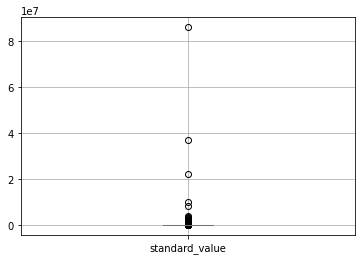

In [ ]:
df_full.boxplot(column=['standard_value'])


We see the standard value (response variable) is highly skewed to the right, with many outliers.

To improve our model's ability to predict standard values, we will convert the IC50 values to pIC50 using the formula: `-log(IC50 * 10^-9)`

In [ ]:
import pandas as pd
df_full = pd.read_csv('lipinski-complete-dataset.csv')

In [ ]:
df_full

,bioactivity_class,molecule_chembl_id,canonical_smiles,standard_value,Molecular Weight,Number of Hydrogen Donors,Number of Hydrogen Acceptors,OWPC,pIC50
0,active,CHEMBL406146,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,413.0,999.085,13.0,13.0,-1.4355,6.384050
1,active,CHEMBL78946,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,2.0,893.005,12.0,12.0,-1.7361,8.698970
2,active,CHEMBL324109,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,460.0,751.988,8.0,9.0,2.3535,6.337242
3,min effect,CHEMBL114147,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,9000.0,737.895,8.0,8.0,1.9626,5.045757
4,min effect,CHEMBL419949,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,5600.0,828.020,8.0,8.0,3.5739,5.251812
...,...,...,...,...,...,...,...,...,...
10037,inactive,CHEMBL4565226,CC(Cc1cc2ccccc2nc1N)C(=O)NC[C@@]12CCCO[C@@H]1C...,34000.0,383.492,2.0,5.0,2.6975,4.468521
10038,inactive,CHEMBL4520156,Nc1nc2ccccc2cc1CCC(=O)N1CC[C@H]2OCCC[C@@]2(Cc2...,84000.0,429.564,1.0,4.0,4.3900,4.075721
10039,inactive,CHEMBL4585673,Nc1nc2ccccc2cc1CCC(=O)NC[C@@]12CCCO[C@@H]1CCOC2,29000.0,369.465,2.0,5.0,2.4515,4.537602
10040,inactive,CHEMBL4546115,COc1ccc2c(c1)[C@@H](O)[C@@]1(CCN(C(=O)CCc3cc4c...,55000.0,417.509,2.0,5.0,3.2666,4.259637


In [ ]:
df_full['standard_value'].describe()

count    1.004200e+04
mean     3.367766e+04
std      9.751722e+05
min      2.000000e-04
25%      2.600000e+01
50%      2.000000e+02
75%      2.247038e+03
max      8.600000e+07
Name: standard_value, dtype: float64

In [ ]:
## Setting a cutoff to the standad value will help with interpreting test results. Large IC50 values are already poor 
## candidates for clinical trials, so capping pIC50 values at 10000000 will our data more uniform without sacrificing 
## the validity of our conclusions.

In [ ]:
import math 

def standardize_and_conversion(dataset):
    store = []
    for x in dataset['standard_value']:
        ### Setting IC50 value cutoff at 10000000
        if x > 1000000:
            x = 1000000
        
        #### Converting IC50 value to molar values 
        molar_value = x*(10**-9)
        insert = -math.log(molar_value,10)
        store.append(insert)
    return store

In [ ]:
setting = standardize_and_conversion(df_full)

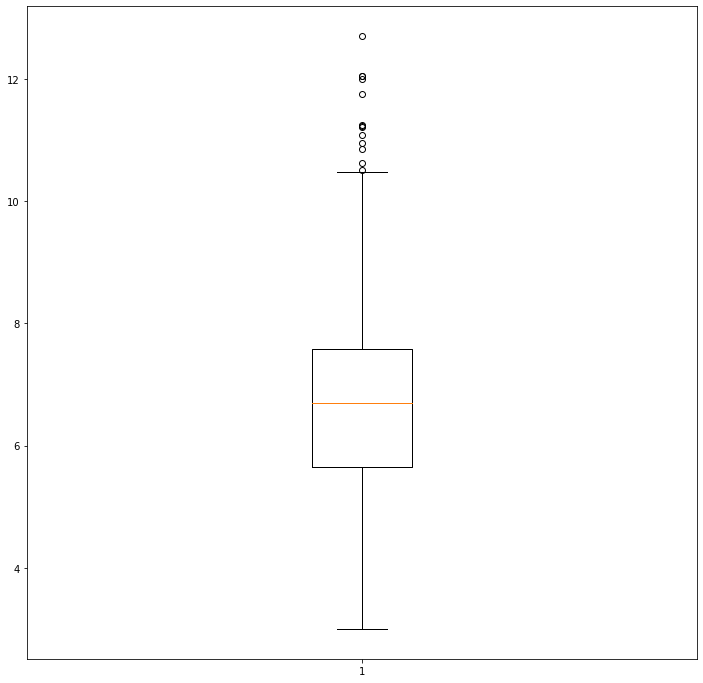

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.boxplot(setting)
plt.savefig('pIC50 values(log1000)')

In [ ]:
setting = pd.Series(setting)
setting.describe()

count    10042.000000
mean         6.580921
std          1.335176
min          3.000000
25%          5.648390
50%          6.698970
75%          7.585027
max         12.698970
dtype: float64

In [ ]:
q3 = setting.quantile(0.75)
q1 = setting.quantile(0.25)

iqr = 1.5*(q3 -q1) + q3
setting.loc[setting > iqr]

4300    10.508638
8327    10.958607
8328    11.086186
8329    11.214670
8330    11.244125
8331    12.045757
8332    12.698970
8333    12.045757
8334    11.744727
8335    12.000000
9270    10.619789
9271    11.221849
9479    10.853872
dtype: float64

In [ ]:
## Since subset of outliers is small(15), removal of these values will be the best course of action as supposed to fitting 
## them into the model.

In [ ]:
insert_2 = setting[setting <= iqr]
df_full['pIC50'] = insert_2

In [ ]:
df_full.pIC50.isnull().count()

10042

In [ ]:
insert_2.count()

10029

In [ ]:
df_full.drop(columns=['pIC50'], inplace=True)
df_full.insert(8, 'pIC50', insert_2)

In [ ]:
df_full

,bioactivity_class,molecule_chembl_id,canonical_smiles,standard_value,Molecular Weight,Number of Hydrogen Donors,Number of Hydrogen Acceptors,OWPC,pIC50
0,active,CHEMBL406146,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,413.0,999.085,13.0,13.0,-1.4355,6.384050
1,active,CHEMBL78946,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,2.0,893.005,12.0,12.0,-1.7361,8.698970
2,active,CHEMBL324109,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,460.0,751.988,8.0,9.0,2.3535,6.337242
3,min effect,CHEMBL114147,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,9000.0,737.895,8.0,8.0,1.9626,5.045757
4,min effect,CHEMBL419949,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,5600.0,828.020,8.0,8.0,3.5739,5.251812
...,...,...,...,...,...,...,...,...,...
10037,inactive,CHEMBL4565226,CC(Cc1cc2ccccc2nc1N)C(=O)NC[C@@]12CCCO[C@@H]1C...,34000.0,383.492,2.0,5.0,2.6975,4.468521
10038,inactive,CHEMBL4520156,Nc1nc2ccccc2cc1CCC(=O)N1CC[C@H]2OCCC[C@@]2(Cc2...,84000.0,429.564,1.0,4.0,4.3900,4.075721
10039,inactive,CHEMBL4585673,Nc1nc2ccccc2cc1CCC(=O)NC[C@@]12CCCO[C@@H]1CCOC2,29000.0,369.465,2.0,5.0,2.4515,4.537602
10040,inactive,CHEMBL4546115,COc1ccc2c(c1)[C@@H](O)[C@@]1(CCN(C(=O)CCc3cc4c...,55000.0,417.509,2.0,5.0,3.2666,4.259637


In [ ]:
df_full.pIC50.describe()

count    10029.000000
mean         6.574670
std          1.324505
min          3.000000
25%          5.647817
50%          6.698970
75%          7.585027
max         10.481486
Name: pIC50, dtype: float64

In [ ]:
q3 = df_full['pIC50'].quantile(0.75)
q1 = df_full['pIC50'].quantile(0.25)

iqr = 1.5*(q3 -q1) + q3
df_full['pIC50'].loc[df_full['pIC50'] > iqr]

Series([], Name: pIC50, dtype: float64)

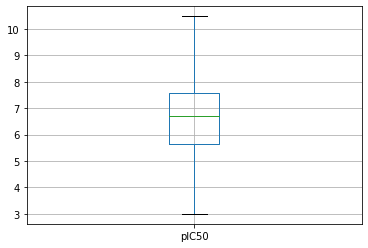

In [ ]:
df_full.boxplot(column='pIC50') ## All outliers have been removed

In [ ]:
## Remove rows that are missing a pIC50 value 
df_full.dropna(inplace=True) ## Datset is now without any outliers in the response variable

In [ ]:
df_full.drop(columns='standard_value', inplace=True)
df_full

,bioactivity_class,molecule_chembl_id,canonical_smiles,Molecular Weight,Number of Hydrogen Donors,Number of Hydrogen Acceptors,OWPC,pIC50
0,active,CHEMBL406146,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,999.085,13.0,13.0,-1.4355,6.384050
1,active,CHEMBL78946,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,893.005,12.0,12.0,-1.7361,8.698970
2,active,CHEMBL324109,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,751.988,8.0,9.0,2.3535,6.337242
3,min effect,CHEMBL114147,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,737.895,8.0,8.0,1.9626,5.045757
4,min effect,CHEMBL419949,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,828.020,8.0,8.0,3.5739,5.251812
...,...,...,...,...,...,...,...,...
10037,inactive,CHEMBL4565226,CC(Cc1cc2ccccc2nc1N)C(=O)NC[C@@]12CCCO[C@@H]1C...,383.492,2.0,5.0,2.6975,4.468521
10038,inactive,CHEMBL4520156,Nc1nc2ccccc2cc1CCC(=O)N1CC[C@H]2OCCC[C@@]2(Cc2...,429.564,1.0,4.0,4.3900,4.075721
10039,inactive,CHEMBL4585673,Nc1nc2ccccc2cc1CCC(=O)NC[C@@]12CCCO[C@@H]1CCOC2,369.465,2.0,5.0,2.4515,4.537602
10040,inactive,CHEMBL4546115,COc1ccc2c(c1)[C@@H](O)[C@@]1(CCN(C(=O)CCc3cc4c...,417.509,2.0,5.0,3.2666,4.259637


In [ ]:
df_full.to_csv('data-no-outliers.csv')

In [ ]:
import pandas as pd
df_full = pd.read_csv('data-no-outliers.csv')

In [ ]:
df_full

,Unnamed: 0,bioactivity_class,molecule_chembl_id,canonical_smiles,Molecular Weight,Number of Hydrogen Donors,Number of Hydrogen Acceptors,OWPC,pIC50
0,0,active,CHEMBL406146,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,999.085,13.0,13.0,-1.4355,6.384050
1,1,active,CHEMBL78946,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,893.005,12.0,12.0,-1.7361,8.698970
2,2,active,CHEMBL324109,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,751.988,8.0,9.0,2.3535,6.337242
3,3,min effect,CHEMBL114147,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,737.895,8.0,8.0,1.9626,5.045757
4,4,min effect,CHEMBL419949,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,828.020,8.0,8.0,3.5739,5.251812
...,...,...,...,...,...,...,...,...,...
10024,10037,inactive,CHEMBL4565226,CC(Cc1cc2ccccc2nc1N)C(=O)NC[C@@]12CCCO[C@@H]1C...,383.492,2.0,5.0,2.6975,4.468521
10025,10038,inactive,CHEMBL4520156,Nc1nc2ccccc2cc1CCC(=O)N1CC[C@H]2OCCC[C@@]2(Cc2...,429.564,1.0,4.0,4.3900,4.075721
10026,10039,inactive,CHEMBL4585673,Nc1nc2ccccc2cc1CCC(=O)NC[C@@]12CCCO[C@@H]1CCOC2,369.465,2.0,5.0,2.4515,4.537602
10027,10040,inactive,CHEMBL4546115,COc1ccc2c(c1)[C@@H](O)[C@@]1(CCN(C(=O)CCc3cc4c...,417.509,2.0,5.0,3.2666,4.259637


In [ ]:
df_full.dropna(inplace=True)
df_full

,Unnamed: 0,bioactivity_class,molecule_chembl_id,canonical_smiles,Molecular Weight,Number of Hydrogen Donors,Number of Hydrogen Acceptors,OWPC,pIC50
0,0,active,CHEMBL406146,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,999.085,13.0,13.0,-1.4355,6.384050
1,1,active,CHEMBL78946,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,893.005,12.0,12.0,-1.7361,8.698970
2,2,active,CHEMBL324109,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,751.988,8.0,9.0,2.3535,6.337242
3,3,min effect,CHEMBL114147,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,737.895,8.0,8.0,1.9626,5.045757
4,4,min effect,CHEMBL419949,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,828.020,8.0,8.0,3.5739,5.251812
...,...,...,...,...,...,...,...,...,...
10024,10037,inactive,CHEMBL4565226,CC(Cc1cc2ccccc2nc1N)C(=O)NC[C@@]12CCCO[C@@H]1C...,383.492,2.0,5.0,2.6975,4.468521
10025,10038,inactive,CHEMBL4520156,Nc1nc2ccccc2cc1CCC(=O)N1CC[C@H]2OCCC[C@@]2(Cc2...,429.564,1.0,4.0,4.3900,4.075721
10026,10039,inactive,CHEMBL4585673,Nc1nc2ccccc2cc1CCC(=O)NC[C@@]12CCCO[C@@H]1CCOC2,369.465,2.0,5.0,2.4515,4.537602
10027,10040,inactive,CHEMBL4546115,COc1ccc2c(c1)[C@@H](O)[C@@]1(CCN(C(=O)CCc3cc4c...,417.509,2.0,5.0,3.2666,4.259637


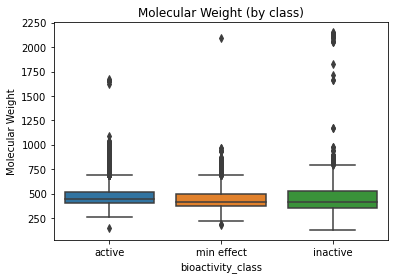

In [ ]:
## Obtain the graphs of descriptors to show differences between class (active, inactive, min Effect)
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='bioactivity_class', y='Molecular Weight', data=df_full)
plt.title('Molecular Weight (by class)')
plt.savefig('Molecular Weight Dist.png')

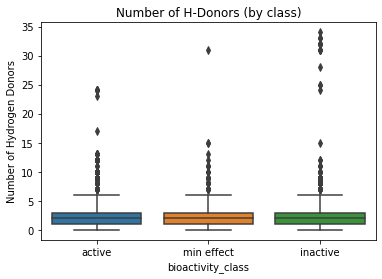

In [ ]:
sns.boxplot(x='bioactivity_class', y='Number of Hydrogen Donors', data=df_full)
plt.title('Number of H-Donors (by class)')
plt.savefig('Number of H-Donors Dist.png')

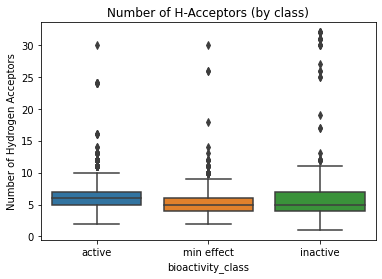

In [ ]:
sns.boxplot(x='bioactivity_class', y='Number of Hydrogen Acceptors', data=df_full)
plt.title('Number of H-Acceptors (by class)')
plt.savefig('Number of H-Acceptors.png')

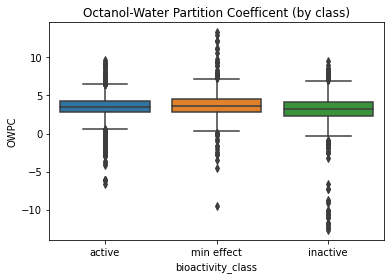

In [ ]:
sns.boxplot(x='bioactivity_class', y='OWPC', data=df_full)
plt.title('Octanol-Water Partition Coefficent (by class)')
plt.savefig('octanol-water partition coefficent.png')

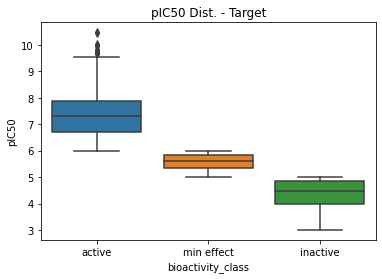

In [ ]:
sns.boxplot(x='bioactivity_class', y='pIC50', data=df_full)
plt.title('pIC50 Dist. - Target')
plt.savefig('pIC50 class pic ')

In [ ]:
## Remove compounds that violates more than one of the Lipinki's Rule of 5:
## . Molecular Weight < 500 daltons
## . Octonal water partition coefficent (logP) < 5
## . Number of hydrogen bond donor < 5
## . Number of Hydrogen bond acceptors < 10

In [ ]:
def lipinski_checker(data):
          
    num_hdonors = data['Number of Hydrogen Donors']
    num_hacceptors = data['Number of Hydrogen Acceptors']
    mol_weight = data['Molecular Weight']
    mol_logp = data['OWPC']
    
    result = []
    
    if num_hdonors > 5:
        result.append(1)
    else:
        result.append(0)
        
    if num_hacceptors > 10:
        result.append(1)
    else:
        result.append(0)
        
    if mol_weight >= 500:
        result.append(1)
    else:
        result.append(0)
        
    if mol_logp >= 5:
        result.append(1)
    else:
        result.append(0)
    
    return result
    
def lipinski_pass(compounds):
    checked_df = {'HD':[], 'HA':[], 'logP':[], 'MW':[]}
    numTrials = len(compounds)
    for x in range(numTrials):
        result = lipinski_checker(compounds.iloc[x])
        checked_df['HD'].append(result[0])
        checked_df['HA'].append(result[1])
        checked_df['logP'].append(result[2])
        checked_df['MW'].append(result[3])
    return checked_df

In [ ]:
checked_df = lipinski_pass(df_full)

In [ ]:
checked_df = pd.DataFrame(checked_df)
checked_df

,HD,HA,logP,MW
0,1,1,1,0
1,1,1,1,0
2,1,0,1,0
3,1,0,1,0
4,1,0,1,0
...,...,...,...,...
10024,0,0,0,0
10025,0,0,0,0
10026,0,0,0,0
10027,0,0,0,0


In [ ]:
checked_df['sum'] = checked_df.sum(axis=1)
checked_df.set_index(df_full['Unnamed: 0'], inplace=True)
checked_df

,HD,HA,logP,MW,sum
Unnamed: 0,,,,,
0,1,1,1,0,3
1,1,1,1,0,3
2,1,0,1,0,2
3,1,0,1,0,2
4,1,0,1,0,2
...,...,...,...,...,...
10037,0,0,0,0,0
10038,0,0,0,0,0
10039,0,0,0,0,0


In [ ]:
checked_df = checked_df.loc[checked_df['sum'] <= 1]
checked_df

,HD,HA,logP,MW,sum
Unnamed: 0,,,,,
12,0,0,0,1,1
18,0,0,1,0,1
21,0,0,1,0,1
24,0,0,1,0,1
133,0,0,1,0,1
...,...,...,...,...,...
10037,0,0,0,0,0
10038,0,0,0,0,0
10039,0,0,0,0,0


In [ ]:
df_full

,Unnamed: 0,bioactivity_class,molecule_chembl_id,canonical_smiles,Molecular Weight,Number of Hydrogen Donors,Number of Hydrogen Acceptors,OWPC,pIC50
0,0,active,CHEMBL406146,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,999.085,13.0,13.0,-1.4355,6.384050
1,1,active,CHEMBL78946,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,893.005,12.0,12.0,-1.7361,8.698970
2,2,active,CHEMBL324109,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,751.988,8.0,9.0,2.3535,6.337242
3,3,min effect,CHEMBL114147,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,737.895,8.0,8.0,1.9626,5.045757
4,4,min effect,CHEMBL419949,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,828.020,8.0,8.0,3.5739,5.251812
...,...,...,...,...,...,...,...,...,...
10024,10037,inactive,CHEMBL4565226,CC(Cc1cc2ccccc2nc1N)C(=O)NC[C@@]12CCCO[C@@H]1C...,383.492,2.0,5.0,2.6975,4.468521
10025,10038,inactive,CHEMBL4520156,Nc1nc2ccccc2cc1CCC(=O)N1CC[C@H]2OCCC[C@@]2(Cc2...,429.564,1.0,4.0,4.3900,4.075721
10026,10039,inactive,CHEMBL4585673,Nc1nc2ccccc2cc1CCC(=O)NC[C@@]12CCCO[C@@H]1CCOC2,369.465,2.0,5.0,2.4515,4.537602
10027,10040,inactive,CHEMBL4546115,COc1ccc2c(c1)[C@@H](O)[C@@]1(CCN(C(=O)CCc3cc4c...,417.509,2.0,5.0,3.2666,4.259637


In [ ]:
checked_df = pd.merge(checked_df, df_full, on='Unnamed: 0')
checked_df

,Unnamed: 0,HD,HA,logP,MW,sum,bioactivity_class,molecule_chembl_id,canonical_smiles,Molecular Weight,Number of Hydrogen Donors,Number of Hydrogen Acceptors,OWPC,pIC50
0,12,0,0,0,1,1,active,CHEMBL142715,c1ccc(-c2ccc(COc3ccc4c(c3)CCC(CCN3CCCCC3)C4)cc...,425.616,0.0,2.0,6.9135,6.455932
1,18,0,0,1,0,1,active,CHEMBL143687,COC(=O)c1cc(NC(=O)[C@@H](NC(=O)C[C@H](O)[C@H](...,745.776,5.0,9.0,4.4964,6.920819
2,21,0,0,1,0,1,min effect,CHEMBL82270,CC(C)[C@H](F)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1cc...,599.748,5.0,6.0,2.4520,5.946922
3,24,0,0,1,0,1,min effect,CHEMBL84835,CC(C)CC(=O)N[C@@H](C)C(=O)N[C@@H](Cc1ccccc1)[C...,581.758,5.0,6.0,2.5040,5.759451
4,133,0,0,1,0,1,active,CHEMBL296166,COC(=O)[C@@H]1CC(NC(=O)[C@H](NC(=O)C[C@H](O)[C...,751.824,5.0,9.0,3.5316,6.920819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8915,10037,0,0,0,0,0,inactive,CHEMBL4565226,CC(Cc1cc2ccccc2nc1N)C(=O)NC[C@@]12CCCO[C@@H]1C...,383.492,2.0,5.0,2.6975,4.468521
8916,10038,0,0,0,0,0,inactive,CHEMBL4520156,Nc1nc2ccccc2cc1CCC(=O)N1CC[C@H]2OCCC[C@@]2(Cc2...,429.564,1.0,4.0,4.3900,4.075721
8917,10039,0,0,0,0,0,inactive,CHEMBL4585673,Nc1nc2ccccc2cc1CCC(=O)NC[C@@]12CCCO[C@@H]1CCOC2,369.465,2.0,5.0,2.4515,4.537602
8918,10040,0,0,0,0,0,inactive,CHEMBL4546115,COc1ccc2c(c1)[C@@H](O)[C@@]1(CCN(C(=O)CCc3cc4c...,417.509,2.0,5.0,3.2666,4.259637


In [ ]:
checked_df.drop(columns='Unnamed: 0', inplace=True)
checked_df

,HD,HA,logP,MW,sum,bioactivity_class,molecule_chembl_id,canonical_smiles,Molecular Weight,Number of Hydrogen Donors,Number of Hydrogen Acceptors,OWPC,pIC50
0,0,0,0,1,1,active,CHEMBL142715,c1ccc(-c2ccc(COc3ccc4c(c3)CCC(CCN3CCCCC3)C4)cc...,425.616,0.0,2.0,6.9135,6.455932
1,0,0,1,0,1,active,CHEMBL143687,COC(=O)c1cc(NC(=O)[C@@H](NC(=O)C[C@H](O)[C@H](...,745.776,5.0,9.0,4.4964,6.920819
2,0,0,1,0,1,min effect,CHEMBL82270,CC(C)[C@H](F)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1cc...,599.748,5.0,6.0,2.4520,5.946922
3,0,0,1,0,1,min effect,CHEMBL84835,CC(C)CC(=O)N[C@@H](C)C(=O)N[C@@H](Cc1ccccc1)[C...,581.758,5.0,6.0,2.5040,5.759451
4,0,0,1,0,1,active,CHEMBL296166,COC(=O)[C@@H]1CC(NC(=O)[C@H](NC(=O)C[C@H](O)[C...,751.824,5.0,9.0,3.5316,6.920819
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8915,0,0,0,0,0,inactive,CHEMBL4565226,CC(Cc1cc2ccccc2nc1N)C(=O)NC[C@@]12CCCO[C@@H]1C...,383.492,2.0,5.0,2.6975,4.468521
8916,0,0,0,0,0,inactive,CHEMBL4520156,Nc1nc2ccccc2cc1CCC(=O)N1CC[C@H]2OCCC[C@@]2(Cc2...,429.564,1.0,4.0,4.3900,4.075721
8917,0,0,0,0,0,inactive,CHEMBL4585673,Nc1nc2ccccc2cc1CCC(=O)NC[C@@]12CCCO[C@@H]1CCOC2,369.465,2.0,5.0,2.4515,4.537602
8918,0,0,0,0,0,inactive,CHEMBL4546115,COc1ccc2c(c1)[C@@H](O)[C@@]1(CCN(C(=O)CCc3cc4c...,417.509,2.0,5.0,3.2666,4.259637


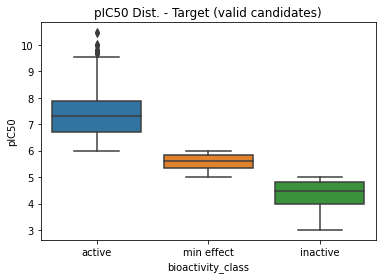

In [ ]:
sns.boxplot(x='bioactivity_class', y='pIC50', data=checked_df)
plt.title('pIC50 Dist. - Target (valid candidates)')
plt.savefig('pIC50 class pic (pass Lipinski) ')

In [ ]:
valid_compounds_classification = checked_df[checked_df.bioactivity_class != 'min effect']

In [ ]:
valid_compounds_classification.to_csv('df_ready_classification.csv')

In [ ]:
checked_df.to_csv('df-ready-regression.csv')

In [ ]:
### Now data is prepared for feature engineering: obtaining 1D/2D descriptors for compound library. 
import pandas as pd

data_1 = pd.read_csv('df-ready-regression.csv')
data_2 = pd.read_csv('df_ready_classification.csv')

In [ ]:
selections = ['canonical_smiles', 'molecule_chembl_id']

df_reg = data_1[selections]
df_class = data_2[selections]

In [ ]:
df_reg.to_csv('Padel_regression_ready.smi', sep='\t', index=False, header=False)

In [ ]:
data_1

,Unnamed: 0,HD,HA,logP,MW,sum,bioactivity_class,molecule_chembl_id,canonical_smiles,Molecular Weight,Number of Hydrogen Donors,Number of Hydrogen Acceptors,OWPC,pIC50
0,0,0,0,0,1,1,active,CHEMBL142715,c1ccc(-c2ccc(COc3ccc4c(c3)CCC(CCN3CCCCC3)C4)cc...,425.616,0.0,2.0,6.9135,6.455932
1,1,0,0,1,0,1,active,CHEMBL143687,COC(=O)c1cc(NC(=O)[C@@H](NC(=O)C[C@H](O)[C@H](...,745.776,5.0,9.0,4.4964,6.920819
2,2,0,0,1,0,1,min effect,CHEMBL82270,CC(C)[C@H](F)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1cc...,599.748,5.0,6.0,2.4520,5.946922
3,3,0,0,1,0,1,min effect,CHEMBL84835,CC(C)CC(=O)N[C@@H](C)C(=O)N[C@@H](Cc1ccccc1)[C...,581.758,5.0,6.0,2.5040,5.759451
4,4,0,0,1,0,1,active,CHEMBL296166,COC(=O)[C@@H]1CC(NC(=O)[C@H](NC(=O)C[C@H](O)[C...,751.824,5.0,9.0,3.5316,6.920819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8915,8915,0,0,0,0,0,inactive,CHEMBL4565226,CC(Cc1cc2ccccc2nc1N)C(=O)NC[C@@]12CCCO[C@@H]1C...,383.492,2.0,5.0,2.6975,4.468521
8916,8916,0,0,0,0,0,inactive,CHEMBL4520156,Nc1nc2ccccc2cc1CCC(=O)N1CC[C@H]2OCCC[C@@]2(Cc2...,429.564,1.0,4.0,4.3900,4.075721
8917,8917,0,0,0,0,0,inactive,CHEMBL4585673,Nc1nc2ccccc2cc1CCC(=O)NC[C@@]12CCCO[C@@H]1CCOC2,369.465,2.0,5.0,2.4515,4.537602
8918,8918,0,0,0,0,0,inactive,CHEMBL4546115,COc1ccc2c(c1)[C@@H](O)[C@@]1(CCN(C(=O)CCc3cc4c...,417.509,2.0,5.0,3.2666,4.259637


In [ ]:
df_class.to_csv('Padel_classification_ready.smi', sep='\t', index=False, header=False)

In [ ]:
data_2

,Unnamed: 0,HD,HA,logP,MW,sum,bioactivity_class,molecule_chembl_id,canonical_smiles,Molecular Weight,Number of Hydrogen Donors,Number of Hydrogen Acceptors,OWPC,pIC50
0,0,0,0,0,1,1,active,CHEMBL142715,c1ccc(-c2ccc(COc3ccc4c(c3)CCC(CCN3CCCCC3)C4)cc...,425.616,0.0,2.0,6.9135,6.455932
1,1,0,0,1,0,1,active,CHEMBL143687,COC(=O)c1cc(NC(=O)[C@@H](NC(=O)C[C@H](O)[C@H](...,745.776,5.0,9.0,4.4964,6.920819
2,4,0,0,1,0,1,active,CHEMBL296166,COC(=O)[C@@H]1CC(NC(=O)[C@H](NC(=O)C[C@H](O)[C...,751.824,5.0,9.0,3.5316,6.920819
3,5,0,0,1,0,1,inactive,CHEMBL296166,COC(=O)[C@@H]1CC(NC(=O)[C@H](NC(=O)C[C@H](O)[C...,751.824,5.0,9.0,3.5316,5.000000
4,6,0,0,1,0,1,inactive,CHEMBL53668,COC(=O)[C@@H]1CC(NC(=O)[C@@H](NC(=O)C[C@H](O)[...,655.789,5.0,9.0,2.5430,3.853872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7191,8915,0,0,0,0,0,inactive,CHEMBL4565226,CC(Cc1cc2ccccc2nc1N)C(=O)NC[C@@]12CCCO[C@@H]1C...,383.492,2.0,5.0,2.6975,4.468521
7192,8916,0,0,0,0,0,inactive,CHEMBL4520156,Nc1nc2ccccc2cc1CCC(=O)N1CC[C@H]2OCCC[C@@]2(Cc2...,429.564,1.0,4.0,4.3900,4.075721
7193,8917,0,0,0,0,0,inactive,CHEMBL4585673,Nc1nc2ccccc2cc1CCC(=O)NC[C@@]12CCCO[C@@H]1CCOC2,369.465,2.0,5.0,2.4515,4.537602
7194,8918,0,0,0,0,0,inactive,CHEMBL4546115,COc1ccc2c(c1)[C@@H](O)[C@@]1(CCN(C(=O)CCc3cc4c...,417.509,2.0,5.0,3.2666,4.259637


### QSAR Regression Modeling

In [ ]:
!wget https://raw.githubusercontent.com/ashiwoku/QSAR-model/main/data%20folder/regression_model_data.csv
!wget https://raw.githubusercontent.com/ashiwoku/QSAR-model/main/data%20folder/classification_model_data.csv

In [22]:
## Get training and test sets for the regression model. 
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

regression_data = pd.read_csv('regression_model_data.csv')
regression_data.drop(columns='Unnamed: 0', inplace=True)

In [23]:
X = regression_data.drop(columns='pIC50')
y = regression_data.pIC50

#### Multiple Linear Regression with Polynomial terms

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44)

In [25]:
### Now, run models again for regression type data.
## First model will be a multiple linear regression model. 
from sklearn.linear_model import LinearRegression
MLR = LinearRegression().fit(X_train, y_train)

In [26]:
r_sq = MLR.score(X_train, y_train)  ## Calculate the R^2 value to determine model fit 
r_sq

0.33281408189168216

In [27]:
predictions = MLR.predict(X_test)

In [28]:
import numpy as np
print(np.sqrt(mean_squared_error(y_test, predictions)))

0.9856798535474988


In [29]:
print(mean_absolute_error(y_test, predictions))

0.7805618137797512


Text(0, 0.5, 'Predicted Values')

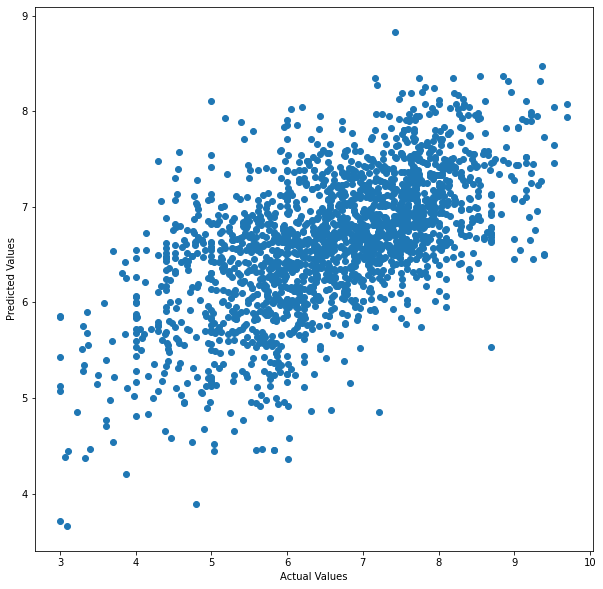

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [31]:
## The results from the multiple linear regression is quite poor, with lots of unexplained variance in our response having 
## no connection to our selected features.The model shows a poor RMSE which is anouhter sign of underfitting our data.

In [32]:
## By looking at the results of the regression and the support vector classification that a linear relationship is not 
## present in the model. To imporve the perfomance of the linear model, we should include higher order polynomials to help
## capture the nonlinear relationship.

In [33]:
## Now calculate the polynmial features for the set. we will compute up to the third order polynomial.
from sklearn.preprocessing import PolynomialFeatures
poly_data = PolynomialFeatures(2)
X_poly = poly_data.fit_transform(X)

In [34]:
## Before we calculate the poynomials, we should rescale the data using StandardScaler.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_poly = scaler.fit_transform(X_poly)

In [35]:
print("The old dataset had the shape: {}; the new dataset has the shape: {}".format(X.shape,X_scaled_poly.shape))

The old dataset had the shape: (8189, 33); the new dataset has the shape: (8189, 595)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_poly, y, test_size=0.25, random_state=44)

In [37]:
MLR_2 = LinearRegression().fit(X_train, y_train)

In [38]:
r_sq = MLR_2.score(X_train, y_train)  ## Calculate the R^2 value to determine model fit 
r_sq

0.5965943949613286

In [39]:
## we see a much improved R^2 value, but lets look at other metrics to see if we avoided overfitting.

In [40]:
predictions = MLR_2.predict(X_test)

In [41]:
print(mean_squared_error(y_test, predictions))

62.27637609148729


Text(0, 0.5, 'Predicted Values')

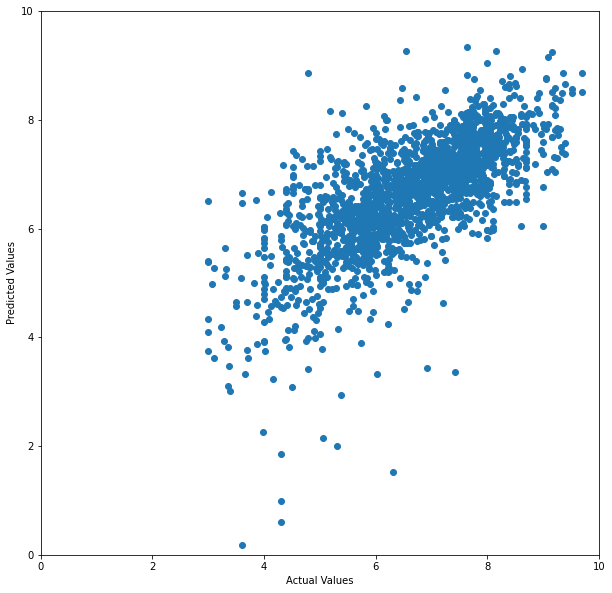

In [42]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.xlim(0,10)
plt.ylim(0,10)
plt.ylabel('Predicted Values')

In [43]:
print(mean_absolute_error(y_test, predictions))

0.9265378654576283


In [44]:
predictions

array([7.46916951, 6.58621388, 6.5912927 , ..., 5.97718561, 5.83458083,
       6.7612483 ])

In [45]:
## the results show that despite the impressive model fit, the model seems to make the poor decision of predicting 0 for 
## most , if not all, model instances.

#### Support Vector Regression

In [47]:
## Utilizing the non-linear kernels in support vector machines may allow for better modeling on the non-linear data
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44)

In [48]:
SVR_pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf',C=0.6))
SVR_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=0.6, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [49]:
predictions = SVR_pipeline.predict(X_test)

In [50]:
print("The mean absolute error: {}".format(mean_absolute_error(y_test, predictions)))

The mean absolute error: 0.6080520387818555


In [51]:
print("The root mean squared error: {}".format(np.sqrt(mean_squared_error(y_test, predictions))))

The root mean squared error: 0.8213411966869646


Text(0, 0.5, 'Predicted Values')

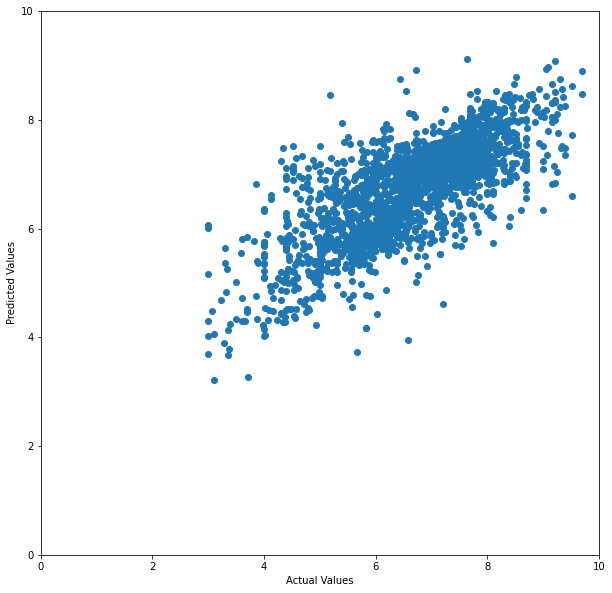

In [52]:
plt.figure(figsize=(10,10))
best = plt.scatter(y_test, predictions)

plt.xlim(0,10)
plt.ylim(0,10)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [53]:
SVR_pipeline.score(X_train, y_train)  ## R^2 value

0.5963523645014688

In [54]:
X.shape

(8189, 33)

#### Feed Forward Neural Network

In [55]:
## we will be using a deep neural network to predict the pIC50 value, while utilizing K-fold cross validation. 
## First define the nearual network architecture.
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold, cross_val_score 

def deep_learning_model():
    model = Sequential()
    model.add(Dense(120, input_dim=33, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [56]:
deep_model = deep_learning_model()
deep_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               4080      
_________________________________________________________________
dense_1 (Dense)              (None, 60)                7260      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 11,401
Trainable params: 11,401
Non-trainable params: 0
_________________________________________________________________


In [58]:
deep_model.fit(X_train, y_train, epochs=150, shuffle=True, verbose=1)

Epoch 1/150
192/192 [==============================] - 0s 2ms/step - loss: 1.1727
Epoch 2/150
192/192 [==============================] - 0s 2ms/step - loss: 1.1851
Epoch 3/150
192/192 [==============================] - 0s 2ms/step - loss: 1.2179
Epoch 4/150
192/192 [==============================] - 0s 2ms/step - loss: 1.1766
Epoch 5/150
192/192 [==============================] - 0s 2ms/step - loss: 5.5520
Epoch 6/150
192/192 [==============================] - 0s 2ms/step - loss: 2.4367
Epoch 7/150
192/192 [==============================] - 0s 2ms/step - loss: 1.7157
Epoch 8/150
192/192 [==============================] - 0s 2ms/step - loss: 1.6450
Epoch 9/150
192/192 [==============================] - 0s 2ms/step - loss: 1.5563
Epoch 10/150
192/192 [==============================] - 0s 2ms/step - loss: 1.6898
Epoch 11/150
192/192 [==============================] - 0s 2ms/step - loss: 1.5959
Epoch 12/150
192/192 [==============================] - 0s 2ms/step - loss: 1.5898
Epoch 13/150


In [59]:
predictions = deep_model.predict(X_test)

In [60]:
print("The mean absolute error: {}".format(mean_absolute_error(y_test, predictions)))

The mean absolute error: 0.7608941742696558


In [61]:
print("The root mean squared error: {}". format(np.sqrt(mean_squared_error(y_test, predictions))))

The root mean squared error: 0.9825655246221323


Text(0, 0.5, 'Predicted Values')

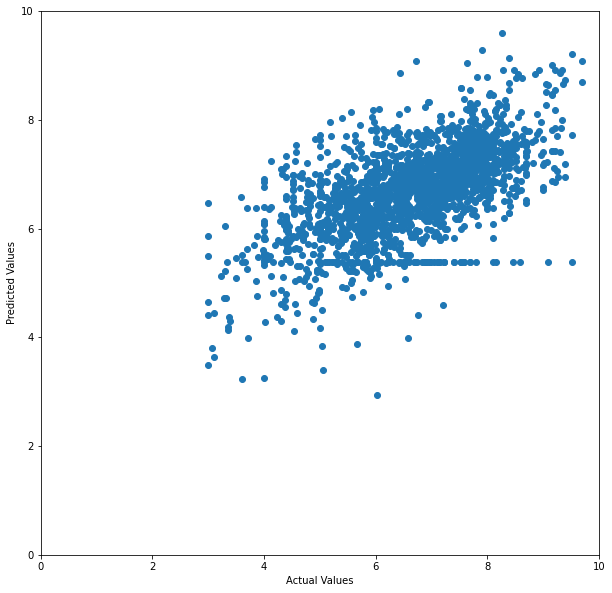

In [62]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions)

plt.xlim(0,10)
plt.ylim(0,10)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [ ]:
## Despite using a neural network and achieving good measurements for the training data, we get poor predictions of desired
## dependent variable, pIC50. Based on the results of the three regression models, this current dataset would be a poor 
## application for reression type model. The solution would be to make adjustments to the way features were selected, 
## perhaps using more domain expertise to select features.

In [ ]:
## make x and y axis the same values

### QSAR Classification Modeling

In [63]:
## import packages and data 
import pandas as pd
class_data = pd.read_csv('classification_model_data.csv')

In [64]:
class_data

,Unnamed: 0,naAromAtom,nAtom,nN,nO,nS,nF,BCUTw.1h,BCUTp.1l,nBondsD,SpMax1_Bhs,SpMax2_Bhs,C2SP1,C1SP2,C2SP2,C3SP2,C1SP3,C4SP3,SCH.7,VC.3,SPC.4,MIC0,nAtomLAC,piPC6,R_TpiPCTPC,n5Ring,n6Ring,nF9Ring,nF10Ring,nFG12Ring,n6HeteroRing,VE3_D,VR1_D,class_label
0,1,18,67,1,1,0,0,15.994923,6.656434,0,4.067311,3.958868,0,0,13,5,4,0,0.526808,0.918921,3.521444,9.437713,2,6.220839,6.373533,0,5,0,1,0,1,-17.743103,432.667502,1
1,2,24,95,3,9,0,2,18.999422,4.235250,5,4.962450,4.854153,0,5,18,6,2,0,0.466026,1.710505,8.678031,16.416644,5,6.607241,5.225156,0,4,0,0,0,0,-11.027942,676.229552,1
2,3,18,101,3,9,0,2,18.999422,4.235268,5,5.102220,5.006018,0,5,14,4,2,0,0.466026,1.906409,8.678031,16.078841,5,6.343551,4.295698,0,4,0,0,0,0,-11.027942,676.229552,1
3,4,18,101,3,9,0,2,18.999422,4.235268,5,5.102220,5.006018,0,5,14,4,2,0,0.466026,1.906409,8.678031,16.078841,5,6.343551,4.295698,0,4,0,0,0,0,-11.027942,676.229552,2
4,5,10,96,3,9,0,0,16.003008,4.686416,5,4.894601,4.890224,0,5,7,3,4,0,0.369227,2.070818,7.893513,14.176615,7,6.093005,3.907792,0,3,0,1,0,0,-22.814477,664.521515,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536,6537,18,43,5,3,0,0,34.970157,5.262839,2,4.713251,4.097320,0,4,11,2,1,0,0.881779,1.151579,5.764985,23.230002,0,6.556956,6.528826,1,4,0,2,1,3,-3.209592,324.625997,1
6537,6538,18,56,4,3,0,0,15.996941,5.125397,2,4.110385,3.996862,2,3,9,6,4,0,0.878711,1.033909,5.843536,14.049195,3,6.996167,9.709851,1,5,0,2,1,4,-6.752213,738.417527,1
6538,6539,18,56,4,3,0,0,15.996941,5.125373,2,4.110480,3.997065,2,3,9,6,4,0,0.878711,1.033909,5.843536,14.049195,3,6.996167,9.709851,1,5,0,2,1,4,-6.752213,738.417527,1
6539,6540,24,53,5,2,0,1,18.998409,4.119742,1,4.754792,4.093080,2,5,10,6,2,0,0.951231,1.063975,6.192701,15.888011,3,7.176446,12.045330,1,5,0,2,1,4,-7.820949,565.660388,1


In [65]:
class_data.drop(columns='Unnamed: 0', inplace=True)

In [66]:
class_data['class_label'].replace({1:0,2:1}, inplace=True)

In [67]:
X = class_data.drop(columns='class_label')
y = class_data['class_label']

In [68]:
y.value_counts()

0    5590
1     951
Name: class_label, dtype: int64

In [69]:
## Split data into train and test sets. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=44)

#### Random Forest Classifier - Classification

In [70]:
## First run a random forest model.
from sklearn.ensemble import RandomForestClassifier

In [71]:
forest = RandomForestClassifier(n_estimators=150, random_state=42)

In [72]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [73]:
predictions = forest.predict(X_test)

In [74]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error

In [75]:
accuracy_score(y_test, predictions)

0.9284841075794621

In [76]:
### The random Forest achieves a 93% accuracy score on the classification dataset. 
### Issues: this is only a binary classification, with severe class imbalance.

In [77]:
confusion_matrix(y_test, predictions)

array([[1372,   26],
       [  91,  147]])

In [78]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1398
           1       0.85      0.62      0.72       238

    accuracy                           0.93      1636
   macro avg       0.89      0.80      0.84      1636
weighted avg       0.92      0.93      0.92      1636



In [79]:
## Classification report shows a better diagnosis of the model. By analyzing the recall score, the recall score of the 
## minority class is concerning. The model was only able to recognize 62% of inactive compunds. To remedy this issue, lets
## implemenet SMOTE analysis to generate sample of the minority class.

In [80]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [81]:
forest_2 = RandomForestClassifier(n_estimators=150, random_state=42)
forest_2.fit(X_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [83]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 4192]
 [   1 4192]]


In [84]:
predictions = forest_2.predict(X_test)

In [85]:
confusion_matrix(y_test, predictions)

array([[1351,   47],
       [  73,  165]])

In [86]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1398
           1       0.78      0.69      0.73       238

    accuracy                           0.93      1636
   macro avg       0.86      0.83      0.85      1636
weighted avg       0.92      0.93      0.92      1636



In [87]:
### Even though the model has slightly lower precision, the recall for the minority class is much improved, which means
### this model was betetr at recognizing the minorty label.

#### Logistic Regression - Classification

In [88]:
## next model is the logistic regression.
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [89]:
predictions = lr.predict(X_test)

In [90]:
accuracy_score(y_test, predictions)

0.8545232273838631

In [91]:
## The logistic regression achieved an accuracy score of 85%

In [92]:
confusion_matrix(y_test, predictions)

array([[1397,    1],
       [ 237,    1]])

In [93]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1398
           1       0.50      0.00      0.01       238

    accuracy                           0.85      1636
   macro avg       0.68      0.50      0.46      1636
weighted avg       0.80      0.85      0.79      1636



In [94]:
## now implement SMOTE analysis.

In [95]:
lr_2 = LogisticRegression(random_state=42)
lr_2.fit(X_train_res,y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [96]:
predictions = lr_2.predict(X_test)

In [97]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1398
           1       0.38      0.16      0.23       238

    accuracy                           0.84      1636
   macro avg       0.63      0.56      0.57      1636
weighted avg       0.80      0.84      0.81      1636



#### Support Vector Machines - Classification

In [98]:
## next model: Support Vector Machines 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(), SVC(kernel='poly', random_state=42))
clf.fit(X_train,y_train)

predictions = clf.predict(X_test)

In [99]:
accuracy_score(y_test, predictions)

0.9083129584352079

In [100]:
## The support Vector Machine achieved an accuracy score of 91%.

In [101]:
confusion_matrix(y_test, predictions)

array([[1378,   20],
       [ 130,  108]])

In [102]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1398
           1       0.84      0.45      0.59       238

    accuracy                           0.91      1636
   macro avg       0.88      0.72      0.77      1636
weighted avg       0.90      0.91      0.90      1636



In [103]:
## Still very poor scores for the minority class using the Support Vector Machine. lets rety using a complete dataset.

In [104]:
clf_2 = make_pipeline(StandardScaler(), SVC(kernel='poly', random_state=42))
clf_2.fit(X_train_res,y_train_res)

predictions = clf_2.predict(X_test)

In [105]:
confusion_matrix(y_test, predictions)

array([[1240,  158],
       [  55,  183]])

In [106]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1398
           1       0.54      0.77      0.63       238

    accuracy                           0.87      1636
   macro avg       0.75      0.83      0.78      1636
weighted avg       0.90      0.87      0.88      1636



In [107]:
## We see whne using a complete dataset, teh model is better able to recognize the minority class without loosing too much 
## informaton from the majority class. But the low precision still shows that the model may be making too many false
## predictions.

In [108]:
## Final model: Feed Forward Neural Network

#### Feed Forward Neural Network - Classification

In [109]:
### Import model packages 
from keras.models import Sequential
from keras.layers import Dense

In [110]:
### Create model. 
def deep_learning_model():
    model = Sequential()
    model.add(Dense(120, input_dim=32, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    ## Compile model
    model.compile(loss='binary_crossentropy',
                 optimizer='adam')
    return model

In [111]:
test = deep_learning_model()
test.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 120)               3960      
_________________________________________________________________
dense_4 (Dense)              (None, 60)                7260      
_________________________________________________________________
dense_5 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
Total params: 13,701
Trainable params: 13,701
Non-trainable params: 0
_________________________________________________________________


In [112]:
X_train.shape

(4905, 32)

In [113]:
test.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
154/154 [==============================] - 1s 2ms/step - loss: 176.7686
Epoch 2/100
154/154 [==============================] - 0s 2ms/step - loss: 882.9578
Epoch 3/100
154/154 [==============================] - 0s 2ms/step - loss: 259.1478
Epoch 4/100
154/154 [==============================] - 0s 2ms/step - loss: 213.6850
Epoch 5/100
154/154 [==============================] - 0s 2ms/step - loss: 68.2308
Epoch 6/100
154/154 [==============================] - 0s 2ms/step - loss: 636.9652
Epoch 7/100
154/154 [==============================] - 0s 2ms/step - loss: 528.6803
Epoch 8/100
154/154 [==============================] - 0s 2ms/step - loss: 376.9674
Epoch 9/100
154/154 [==============================] - 0s 2ms/step - loss: 76.1517
Epoch 10/100
154/154 [==============================] - 0s 2ms/step - loss: 258.6013
Epoch 11/100
154/154 [==============================] - 0s 2ms/step - loss: 291.2351
Epoch 12/100
154/154 [==============================] - 0s 2ms/step - loss: 

In [114]:
predictions = test.predict(X_test)

In [115]:
from sklearn.metrics import recall_score, confusion_matrix, balanced_accuracy_score

recall = recall_score(y_test, predictions.round())
recall

0.38235294117647056

In [116]:
matrix = confusion_matrix(y_test, predictions.round())
matrix

array([[1363,   35],
       [ 147,   91]])

In [117]:
score = balanced_accuracy_score(y_test, predictions.round())
score

0.6786585878986788

In [118]:
from sklearn.metrics import classification_report

class_report = classification_report(y_test, predictions.round())
print(class_report)

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      1398
           1       0.72      0.38      0.50       238

    accuracy                           0.89      1636
   macro avg       0.81      0.68      0.72      1636
weighted avg       0.88      0.89      0.87      1636

